# neural net to find object center, reducing failure rate

### Learning to optimize a Neural Net, part 2
https://medium.com/p/4397922d0243

This experiment is designed to measure the effects of reinitializing the learned weights of a NN. The second post in blog explores different ways to reduce the failure rate.

The failure rate was defined as "proportion of models with loss>0.45 after 2000 epochs of training from scratch".


<img src="PaperNet.jpg">

the initially designed NN has no convolutional layers. The Keras implementation looked like this:
```python
model.add(Dense(4, use_bias=True, activation=None, input_shape=(img_size,)))
model.add(Dense(2, use_bias=True, activation='relu'))
model.add(Dense(1, use_bias=False, activation=None))
```

In the code below, I create multiple versions of this NN. They all have the above architecture, only the initial weights (parameters) are different. Keras initializes the parameters at random using the default algorithm.

## init and import

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import keras

%matplotlib inline

/home/paperspace/anaconda3/envs/bletchley/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### a wee warning
This notebook keeps everything in memory. You might run into problems when increasing img_size or sprawl beyond a certain limit.

## create image functions

In [10]:
def make_blob_images(img_size = 3, normx = False, normy = False):
    """create images (X) and labels (Y) indicating center of the object
    each image has an object and some empty space
    images have height of 1 pixel and width of img_size pixels"""
    
    X = []
    Y = []
    if normx:
        pixelvalue = 1
    else:
        pixelvalue = 2*img_size
    #
    for blob_size in range(1, img_size):
        for start in range(0, img_size - blob_size + 1):
            img = [0] * img_size
            img[start:start+blob_size] = [pixelvalue] * blob_size
            center = start + blob_size/2
            if normy:
                center = center / img_size
            X.append(img)
            Y.append(center)
        #
    #
    X = np.array(X)
    Y = np.array(Y)
    Y = Y.reshape(Y.shape[0], 1)
    return X, Y

In [11]:
def plot_img(x,y_true, normy=False):
    """visualize an image (x) with the center of object (y_true) using matplotlib"""
    if normy:
        y_true = y_true * img_size
    img = x.reshape(1,img_size)
    plt.imshow(img, cmap='binary', extent=[0,img_size,0,1])
    plt.plot([y_true,y_true],[0,1], color='r', linewidth=2)
    plt.xticks(np.arange(0,img_size+1))
    plt.yticks([])
    plt.grid(axis='x')
    plt.show()

## create X and Y: images and blob center values
For a given size of the image. Display one such image.

In [12]:
img_size = 3
X,Y = make_blob_images(img_size, normx=True, normy=True)

In [13]:
i=0

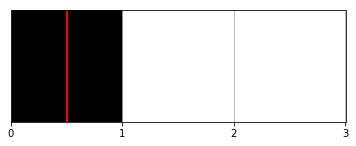

In [14]:
# execute this cell again and again to see more samples of X,Y
x = X[i]
y=Y[i]

plot_img(x,y, normy=True)
i = (i + 1) % len(X) # =0

In [15]:
X.shape

(5, 3)

In [16]:
Y.shape

(5, 1)

In [17]:
print(np.mean(Y))
print(np.std(Y))
print(np.std(Y) ** 2)

0.5
0.23570226039551587
0.055555555555555566


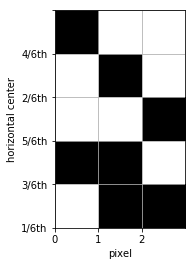

In [18]:
# plot all images in one plot
w = len(X[0])
h = len(X)
nominator = w * 2
nom = "{}th".format(nominator)
enums = []
for i in (Y*nominator).astype(int):
    enums.append("{}/{}".format(i[0], nom))
#

# plt.figure(figsize=(w/2,h/2))
plt.imshow(X, cmap='binary', extent=[0,w,0,h])
plt.grid(axis='both')

plt.xticks(np.arange(0,w),)
plt.yticks(np.arange(0,h+1), enums) # TODO hardcoded values into vars
plt.xlabel("pixel")
plt.ylabel("horizontal center")
plt.show()

## create functions for model handling
Activate the make_model() function that you want to experiment with.

In [111]:
# version all_relu
def make_model(img_size=3):
    """
    create a NN model kinda like the PaperNet architecture
    varies in activation functions and/or bias definitions
    hack this function as experiment demands
    input_shape depends on img_size
    output_shape is 1
    """
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(4, use_bias=True, activation='relu' , input_shape=(img_size,) ) )
    model.add(keras.layers.Dense(2, use_bias=True, activation='relu' ) )
    model.add(keras.layers.Dense(1, use_bias=True, activation='relu' ) )
    model = compile_model(model)
    return model

In [20]:
def clone_model(parent):
    """returns exact, compiled, copy of model with weights and all"""
    model = keras.models.clone_model(parent)
    W = parent.get_weights()
    model.set_weights(W)
    model = compile_model(model)
    return model

In [21]:
def compile_model(model):
    """
    returns compiled PaperNet model with SGD optimizer and hard coded hyperparameters
    loss is defined as MAE (mean absolute error)
    """
    model.compile(optimizer=keras.optimizers.SGD(lr=.01), loss=keras.losses.mean_absolute_error, metrics=['mean_absolute_percentage_error'])
    return model

In [22]:
def train(model, epochs = 100):
    """
    trains model using batch_size=len(X)
    returns training history object
    """
    history = model.fit(x=X, y=Y, epochs=epochs, batch_size=len(X), verbose=False)
    return history

In [24]:
def evaluate(model):
    """evaluates model, returns loss and metrics"""
    return model.evaluate(x=X, y=Y, verbose=False)

In [46]:
def waxon_waxoff(parent=None, sprawl=1, epochs=100): 
    """
    creates sprawl number of models, each with different random weights
    if parent model is given, will clone_model(parent) instead, resulting in sprawl identical models
    each model is trained a given number of epochs
    returns three lists with corresponding index: 
    children (contains model objects),
    stats (contains loss values),
    curves (contains history objects)
    """
    children = []
    stats = []
    curves = []
    
    print("train {} models, train each model for {} epochs".format(sprawl, epochs))
    for r in range(sprawl):
        print(" model:", r)
        if parent == None:
            model = make_model(img_size=img_size)
        else:
            model = clone_model(parent)
        #
        history = train(model=model, epochs = epochs)
        loss = evaluate(model=model)[0]

        children.append(model)
        stats.append(loss)
        curves.append(history)
    #
    return children, stats, curves


In [117]:
def report_experiment(version='baseline'):
    """
    report on an experiment with all the trimmings
    """
    print("Report for experiment titled \'{}\'".format(version))
    print("mean loss: {:.4f}  std dev loss: {:.4f}".format(np.mean(stats[version]), np.std(stats[version])) )
    print("best loss: {:.4f}    worst loss: {:.4f}".format(min(stats[version]), max(stats[version])) )
    print("best model: {}      worst model: {}".format(best[version], worst[version]))
    a=np.array(stats[version])
    b = a > 0.45
    print("failure rate for version {}: {}".format(version, b.sum() /len(b)))
    
    # plot predictions by Best model
    model = generation[version][best[version]]
    y_hat = model.predict(x=X).flatten()
    pos = range(len(Y.flatten()))
    plt.bar(pos, Y.flatten(), -.8, align='center', color='black', label='true')
    plt.bar(pos, y_hat, .3, align='edge', color='#3a9362', label='predict')
    plt.title("{} epochs per training run\npredictions by best of {} models".format(epochs[version], sprawl[version]))
    plt.xlabel("sample image")
    plt.ylabel("output")
    plt.legend()
    plt.show()

    # plot predictions by Worst model
    model = generation[version][worst[version]]
    y_hat = model.predict(x=X).flatten()
    pos = range(len(Y.flatten()))
    plt.bar(pos, Y.flatten(), -.8, align='center', color='black', label='true')
    plt.bar(pos, y_hat, .3, align='edge', color='#3a9362', label='predict')
    plt.title("{} epochs per training run\npredictions by worst of {} models".format(epochs[version], sprawl[version]))
    plt.xlabel("sample image")
    plt.ylabel("output")
    plt.legend()
    plt.show()

    # plot all losses for all models in the experiment
    pos = range(len(stats[version]))
    plt.bar(pos,stats[version])
    plt.title("losses in order, trained {} models for {} epochs".format(sprawl[version], epochs[version]))
    plt.xlabel("model")
    plt.ylabel("loss")
    plt.show()

    # plot histogram of losses of all models in the generation
    plt.hist(x=stats[version], bins=9)
    plt.title("losses histogram, trained {} models for {} epochs".format(sprawl[version], epochs[version]))
    plt.xlabel("loss")
    plt.ylabel("absolute freq.")
    plt.show()

    # plot learning curves for all models in one graph
    nicknames = range(len(curves[version]))
    plt.figure(figsize=(14,6))
    if len(nicknames) > 20:
        gray = True
    else:
        gray = False
    #
    for c in nicknames:
        h = curves[version][c].history['loss']
        if gray:
            plt.plot(h, label=c, color='gray', alpha=0.1)
        else:
            plt.plot(h, label=c)
        #
        plt.xscale("log")
    #
    plt.title("{} models trained for {} epochs\nexperiment titled {}".format(sprawl[version], epochs[version], version))
    if not gray:
        plt.legend()
    #
    plt.xlabel("epoch (log scale)")
    plt.ylabel("loss")
    plt.show()



## improve PaperNet failure rate: different approaches

In [27]:
# from here on, we store results of experiments in these dicts:
generation = {}
stats = {}
curves = {}
best = {}
worst = {}
# experiment's parameters are also stored in dicts:
sprawl = {}
epochs = {}

### Set the baseline from the first notebook

In [28]:
## name the experiment
version = 'papernet' #  a label to give the experiment

In [29]:
## run the experiment
sprawl[version] = 30
epochs[version] = 300
generation[version], stats[version], curves[version] = waxon_waxoff(sprawl = sprawl[version], epochs=epochs[version] )
best[version]  = np.argmin(stats[version])
worst[version] = np.argmax(stats[version])


train 30 models, train each model for 300 epochs
 model: 0
 model: 1
 model: 2
 model: 3
 model: 4
 model: 5
 model: 6
 model: 7
 model: 8
 model: 9
 model: 10
 model: 11
 model: 12
 model: 13
 model: 14
 model: 15
 model: 16
 model: 17
 model: 18
 model: 19
 model: 20
 model: 21
 model: 22
 model: 23
 model: 24
 model: 25
 model: 26
 model: 27
 model: 28
 model: 29


Report for experiment titled 'papernet'
mean loss: 0.1650  std dev loss: 0.1504
best loss: 0.0042    worst loss: 0.5000
best model: 16      worst model: 7
failure rate for version papernet: 0.1


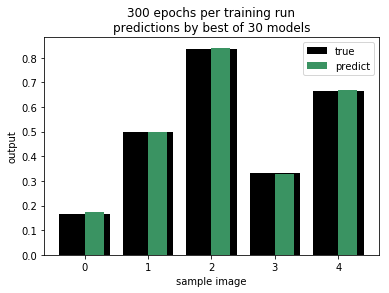

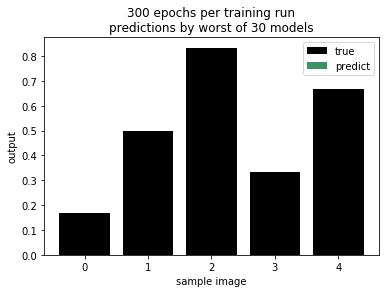

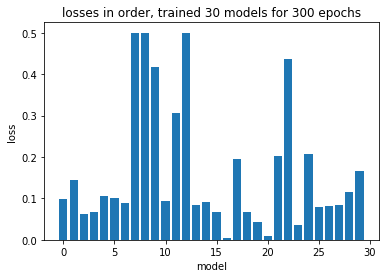

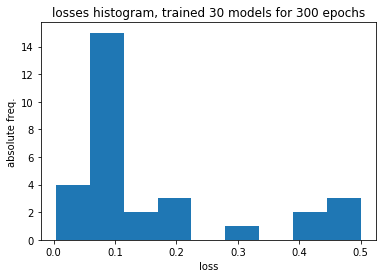

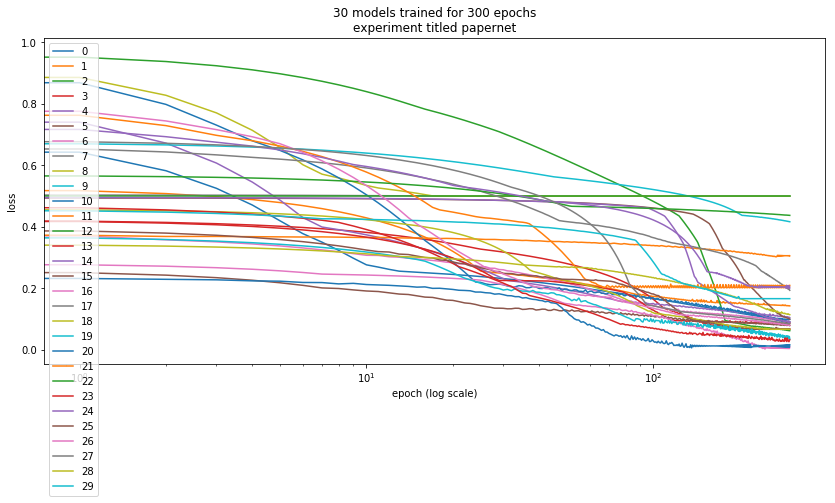

In [30]:
report_experiment(version=version)

### This would be where you hack make_model() to do something different (something similar, it's  up to you)

In [112]:
version = 'all_relu' # don't forget to change make_model() first!

In [115]:
## run the experiment
sprawl[version] = 10
epochs[version] = 2000
generation[version], stats[version], curves[version] = waxon_waxoff(sprawl = sprawl[version], epochs=epochs[version] )
best[version]  = np.argmin(stats[version])
worst[version] = np.argmax(stats[version])

train 10 models, train each model for 2000 epochs
 model: 0
 model: 1
 model: 2
 model: 3
 model: 4
 model: 5
 model: 6
 model: 7
 model: 8
 model: 9


Report for experiment titled 'all_relu'
mean loss: 0.2771  std dev loss: 0.2243
best loss: 0.0095    worst loss: 0.5000
best model: 5      worst model: 1
failure rate for version all_relu: 0.5


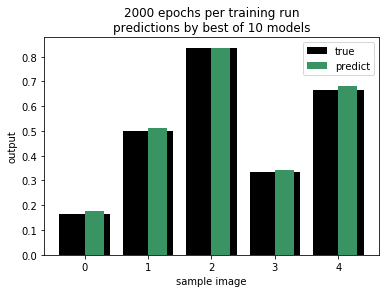

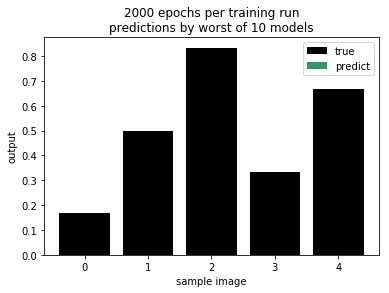

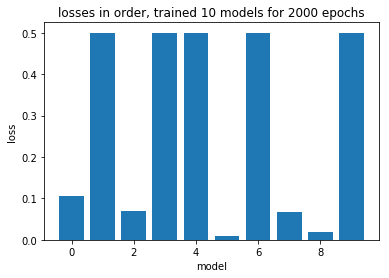

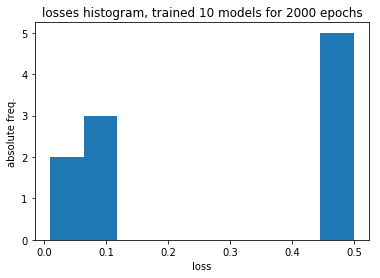

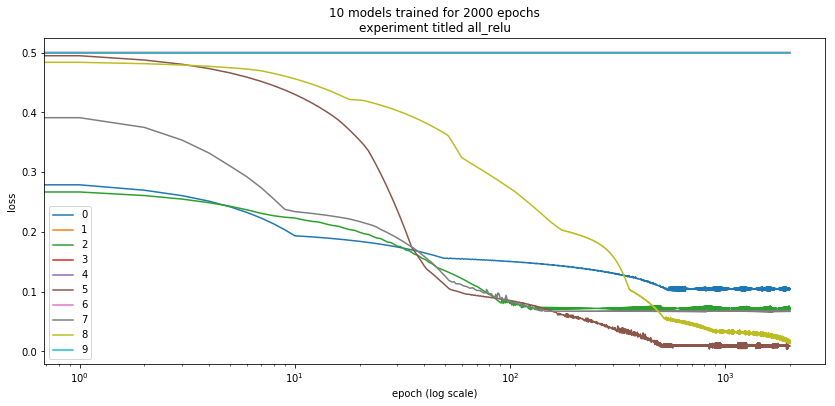

In [118]:
report_experiment(version='all_relu')

In [92]:
# choose the best model and clone, use the clone to parent more models
m = clone_model(generation[version][best[version]])

In [93]:
## run the experiment
sprawl[version] = 2
epochs[version] = 30000
generation[version], stats[version], curves[version] = waxon_waxoff(parent=m, sprawl = sprawl[version], epochs=epochs[version] )
best[version]  = np.argmin(stats[version])
worst[version] = np.argmax(stats[version])


train 2 models, train each model for 30000 epochs
 model: 0
 model: 1


Report for experiment titled 'all_relu'
mean loss: 0.0216  std dev loss: 0.0000
best loss: 0.0216    worst loss: 0.0216
best model: 1      worst model: 0
failure rate for version all_relu: 0.0


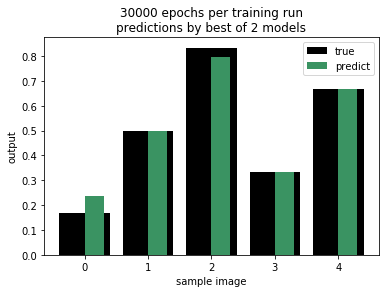

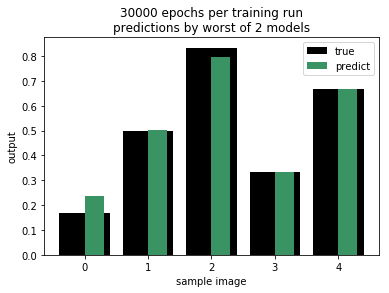

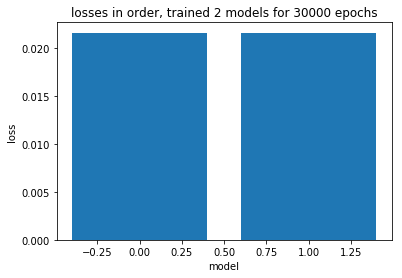

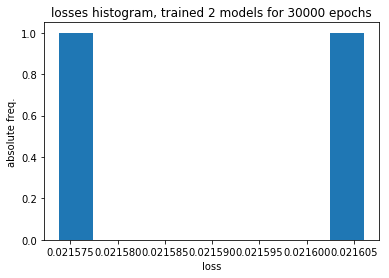

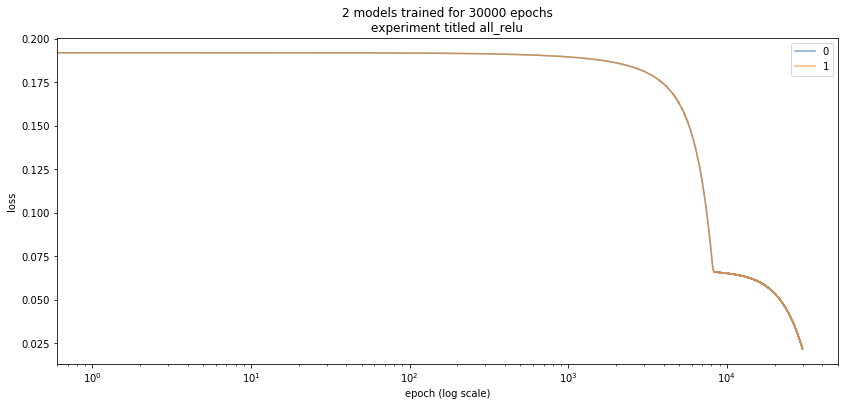

In [94]:
report_experiment(version='all_relu')

### experiment: all layers use Sigmoid activation

In [58]:
version = 'all_sigmoid' # don't forget to change make_model() first!

In [73]:
## run the experiment
sprawl[version] = 4
epochs[version] = 130000
generation[version], stats[version], curves[version] = waxon_waxoff(sprawl = sprawl[version], epochs=epochs[version] )
best[version]  = np.argmin(stats[version])
worst[version] = np.argmax(stats[version])

train 4 models, train each model for 130000 epochs
 model: 0
 model: 1
 model: 2
 model: 3


Report for experiment titled 'all_sigmoid'
mean loss: 0.0007  std dev loss: 0.0001
best loss: 0.0005    worst loss: 0.0009
best model: 3      worst model: 2
failure rate for version all_sigmoid: 0.0


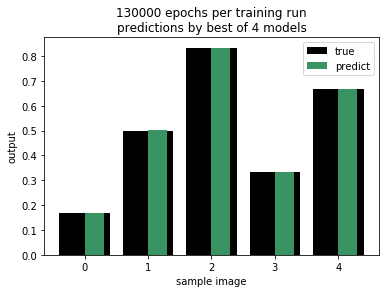

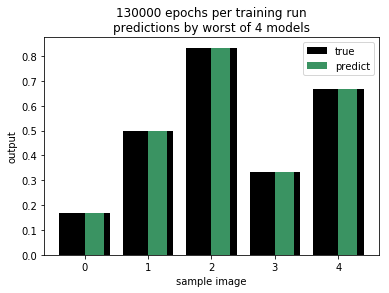

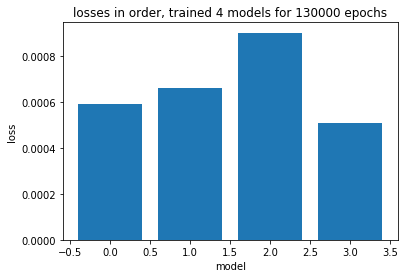

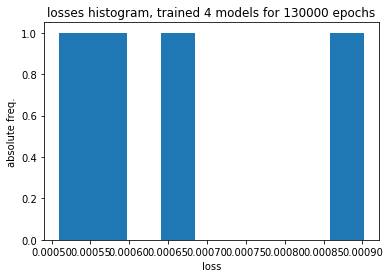

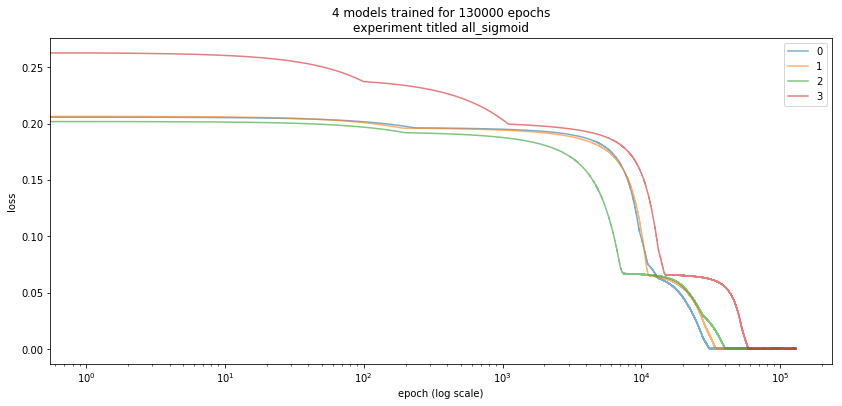

In [86]:
report_experiment(version='all_sigmoid')

In [61]:
m = clone_model(generation['all_sigmoid'][best['all_sigmoid']])

In [62]:
## run the experiment
sprawl[version] = 6
epochs[version] = 6000
generation[version], stats[version], curves[version] = waxon_waxoff(parent=m, sprawl = sprawl[version], epochs=epochs[version] )
best[version]  = np.argmin(stats[version])
worst[version] = np.argmax(stats[version])


train 6 models, train each model for 6000 epochs
 model: 0
 model: 1
 model: 2
 model: 3
 model: 4
 model: 5


In [63]:
print("mean loss: {:.7f}  std dev loss: {:.7f}".format(np.mean(stats[version]), np.std(stats[version])) )

mean loss: 0.0649812  std dev loss: 0.0000000


In [70]:
m = clone_model(generation['all_sigmoid'][best['all_sigmoid']])

In [71]:
## run the experiment
sprawl[version] = 3
epochs[version] = 30000
generation[version], stats[version], curves[version] = waxon_waxoff(parent=m, sprawl = sprawl[version], epochs=epochs[version] )
best[version]  = np.argmin(stats[version])
worst[version] = np.argmax(stats[version])

train 1 models, train each model for 30000 epochs
 model: 0


Report for experiment titled 'all_sigmoid'
mean loss: 0.0008  std dev loss: 0.0000
best loss: 0.0008    worst loss: 0.0008
best model: 0      worst model: 0
failure rate for version all_sigmoid: 0.0


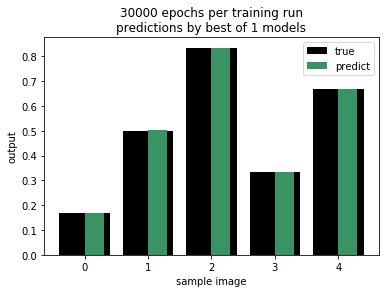

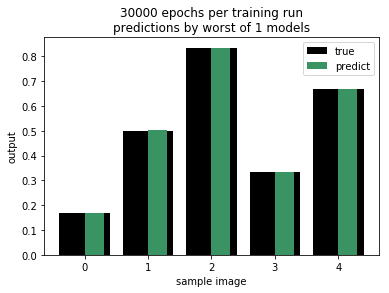

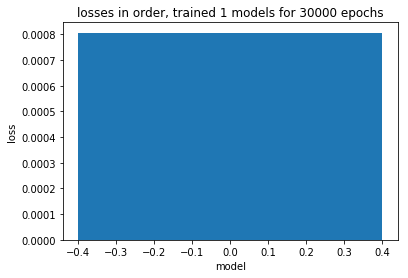

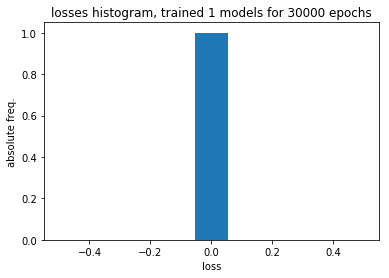

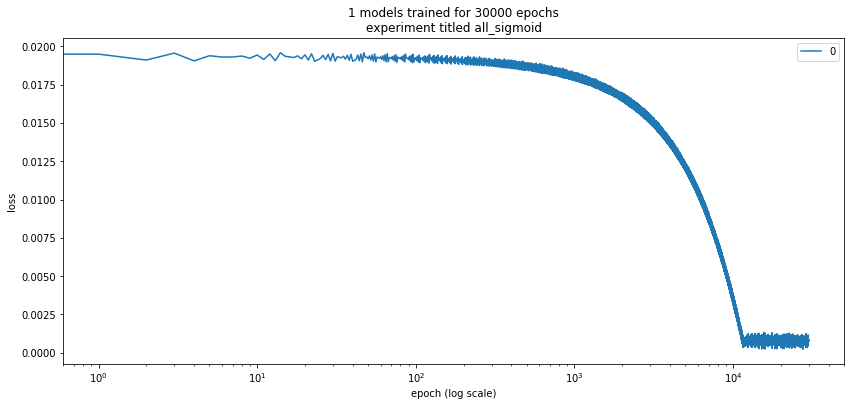

In [72]:
report_experiment(version=version)

## take a look at the activations inside a model

In [119]:
version = 'all_relu'

In [144]:
# create three model clones with decreasing number of layers
model3 = generation[version][worst[version]]
W = model3.get_weights()

model2 = keras.models.clone_model(model3)
model2.set_weights(W)
model2.pop()

model1 = keras.models.clone_model(model3)
model1.set_weights(W)
model1.pop()
model1.pop()

[[0.69584334 0.18796027 0.91724956 0.        ]
 [0.6435555  0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [1.3393989  0.         0.5476174  0.        ]
 [0.37393516 0.         0.         0.        ]]


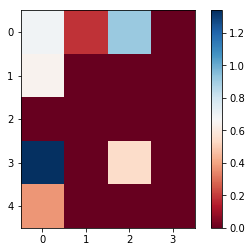

In [145]:
pred1 = model1.predict(x=X)
print(pred1)
plt.imshow(pred1, cmap='RdBu')
plt.colorbar()
plt.show()

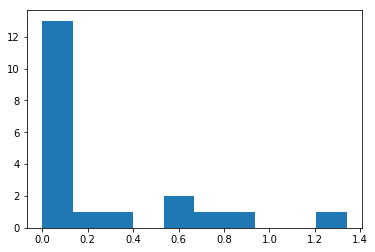

In [146]:
p = pred1.flatten()
plt.hist(p)
plt.show()

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


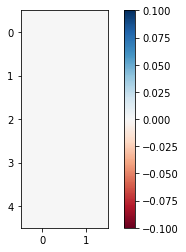

In [147]:
pred2 = model2.predict(x=X)
print(pred2)
plt.imshow(pred2, cmap='RdBu')
plt.colorbar()
plt.show()

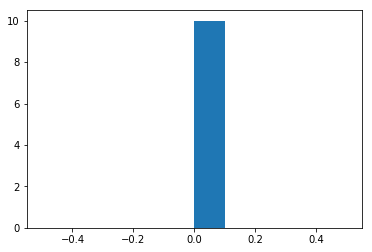

In [148]:
p = pred2.flatten()
plt.hist(p)
plt.show()

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


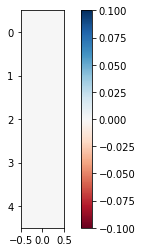

In [149]:
pred3 = model3.predict(x=X)
# print(pred3)
print(pred3)
plt.imshow(pred3, cmap='RdBu')
plt.colorbar()
plt.show()

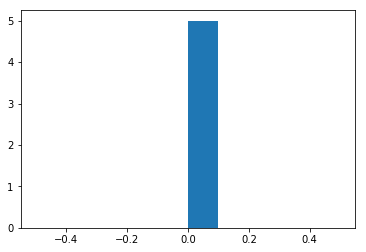

In [150]:
p = pred3.flatten()
plt.hist(p)
plt.show()

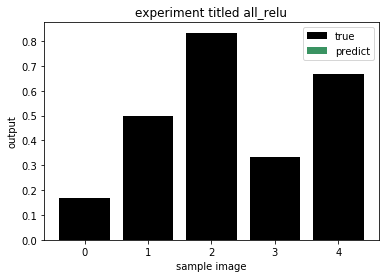

In [151]:
# plot predictions by selected model
y_hat = model3.predict(x=X).flatten()
pos = range(len(Y.flatten()))
plt.bar(pos, Y.flatten(), -.8, align='center', color='black', label='true')
plt.bar(pos, y_hat, .3, align='edge', color='#3a9362', label='predict')
plt.title("experiment titled {}".format(version))
plt.xlabel("sample image")
plt.ylabel("output")
plt.legend()
plt.show()